In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import h5py
from torch.cuda.amp import autocast, GradScaler
from torch.nn.utils import weight_norm

import os

#from load_data import get_model_data

nor_sta_fes1 = torch.from_numpy(pd.read_csv('./data/nor_su_static.csv').to_numpy().astype('float32'))
nor_sta_fes1.shape

/home/jovyan/anaconda3/envs/cgnn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([89, 11])

In [6]:
dys1= torch.from_numpy(np.load('./data/nor_8_dy_series.npy').astype('float32'))
ys1 = torch.from_numpy(pd.read_csv('./data/nor_EWM_deform_60.csv').T.to_numpy().astype('float32'))


exclude_ids = [2,5,13,37,53,56]
indices = list(range(nor_sta_fes1.size(0)))
# 排除指定的索引
indices = [i for i in indices if i not in exclude_ids]

nor_sta_fes = nor_sta_fes1[indices]
dys = dys1[:,:,:,indices]
ys = ys1[:,indices]

x_train = dys[:66]
x_val = dys[66:75]
x_test = dys[75:]

y_train = ys[:66]
y_val = ys[66:75]
y_test = ys[75:]

dys.shape

torch.Size([83, 8, 90, 83])

In [8]:
class OutputLayerWithAttention(nn.Module):
    def __init__(self, c, T, n):
        super(OutputLayerWithAttention, self).__init__()
        self.tconv1 = nn.Conv2d(c, c, (T, 1), 1, dilation=1, padding=(0, 0))
        self.relu3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)
        self.ln = nn.LayerNorm([n, c])
        self.tconv2 = nn.Conv2d(c, c, (1, 1), 1, dilation=1, padding=(0, 0))
        self.relu4 = nn.ReLU()
        self.drop4 = nn.Dropout(0.5)
        self.fc = FullyConvLayer(c)

        # Transformer-Style Attention
        self.attention = nn.MultiheadAttention(embed_dim=c, num_heads=4, batch_first=True)

    def forward(self, x):
        x_t1 = self.relu3(self.tconv1(x))  # [batch_size, channels, height, width]
        x_t1 = self.drop3(x_t1)

        x_ln = self.ln(x_t1.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)  # Layer normalization

        # Attention applied to the last two dimensions
        batch, channels, height, width = x_ln.size()
        x_reshaped = x_ln.view(batch, channels, -1).permute(0, 2, 1)  # [batch, seq_len, channels]
        attn_output, _ = self.attention(x_reshaped, x_reshaped, x_reshaped)  # Apply attention
        x_t2 = attn_output.permute(0, 2, 1).view(batch, channels, height, width)

        x_t2 = self.relu4(self.tconv2(x_t2))
        x_t2 = self.drop4(x_t2)

        return self.fc(x_t2)

In [9]:
class Chomp2d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp2d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        """
        裁剪的模块，裁剪多出来的padding
        """
        return x[:, :, :-self.chomp_size[0], :-self.chomp_size[1]].contiguous()
    
class FullyConvLayer(nn.Module):
    def __init__(self, c):
        super(FullyConvLayer, self).__init__()
        self.conv = nn.Conv2d(c, 1, 1)

    def forward(self, x):
        return self.conv(x)


class OutputLayer(nn.Module):
    def __init__(self, c, T, n):
        super(OutputLayer, self).__init__()
        self.tconv1 = nn.Conv2d(c, c, (T, 1), 1, dilation=1, padding=(0, 0))
        self.relu3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)
        self.ln = nn.LayerNorm([n, c])
        self.tconv2 = nn.Conv2d(c, c, (1, 1), 1, dilation=1, padding=(0, 0))
        self.relu4 = nn.ReLU()
        self.drop4 = nn.Dropout(0.5)
        self.fc = FullyConvLayer(c)
        
        

    def forward(self, x):
        x_t1 = self.relu3(self.tconv1(x))  #out[7, 64, 14, 4398]
        #print(x_t1.shape)
        x_t1 = self.drop3(x_t1)
        
        x_ln = self.ln(x_t1.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
        #print(x_ln.shape)  #[7, 64, 14, 4398]
        x_t2 = self.relu4(self.tconv2(x_ln))
        x_t2 = self.drop4(x_t2) #same size with x_ln

        return self.fc(x_t2)    



class TN_module(nn.Module):
    def __init__(self, c_in, c_out, dropout, dia=1):
        super(TN_module, self).__init__()
        
        self.conv1 = weight_norm(nn.Conv2d(c_in, c_out, (3,1),
                                           stride=1, padding=(0,0), dilation=dia))
        # 经过conv1，输出的size其实是(Batch, input_channel, seq_len + padding)
        self.dropout1 = nn.Dropout(dropout)
        self.chomp1 = Chomp2d((2,0))  # 裁剪掉多出来的padding部分，维持输出时间步为seq_len
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(
            c_out, c_out, (3, 1), 1, dilation=2, padding=(0, 0)
        )  #（2，1）卷积核的尺寸
        self.dropout2 = nn.Dropout(dropout)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv2d(
            c_out, c_out, (3, 1), 1, dilation=4, padding=(0, 0)
        )  #（2，1）卷积核的尺寸
                
        self.dropout3 = nn.Dropout(dropout)
        self.relu3 = nn.ReLU()
        
        self.net = nn.Sequential(self.conv1, self.relu1, self.dropout1,
                                 self.conv2,self.relu2, self.dropout2,
                                self.conv3,self.relu3, self.dropout3,)
        self.init_weights()
        
        self.fc1 = nn.Linear(11,24)
        self.relu = nn.ReLU()
        self.drop1 = nn.Dropout(dropout)
        self.out = OutputLayer(24+c_out, 76, 83)  #18,14
        #self.out = OutputLayerWithAttention(24+c_out, 76, 83)  #18,14
        
    
    def init_weights(self):
        """
        参数初始化
        """
        self.conv1.weight.data.normal_(0, 0.01)
    
    def forward(self, x1,x2):
        
        x1 = self.net(x1)   #[79,7,46,269]
        #x2 = x2.view((13,-1))  #[269,13]
        x2 = self.relu(self.fc1(x2))
        x2 = self.drop1(x2).T
        
        x2 = x2.unsqueeze(0)
        x2 = x2.unsqueeze(2)
        x2 = x2.repeat(x1.shape[0],1,x1.shape[2],1)
        #print(x2.shape)
        #print(x2.shape)
        out = torch.cat((x1, x2), dim=1)
        #print(out.shape)
        # Output layer
        #print(out.shape)
        out = self.out(out).squeeze(1)
        
        return out.squeeze(1)
    
#x2 = x2.unsqueeze(2).repeat(1, 1,x1.shape[2], 1)  ##(2,32,1,23140) --->(2,32,28,23140) 

def torch_corre(y_pre,y_true):
    y_pre = y_pre.view((-1,))
    y_true = y_true.view((-1,))
    #print(y_pre.shape,y_true.shape)
    stacked = torch.stack((y_true, y_pre))
    
    # 计算相关系数矩阵
    corr_matrix = torch.corrcoef(stacked)
    
    # 提取皮尔逊相关系数
    pearson_coefficient = corr_matrix[0, 1]
    
    return pearson_coefficient

In [10]:
class WMSE_loss(nn.Module):
    def __init__(self):
        super(WMSE_loss,self).__init__()
    def forward(self,y_pred,y_true):
        
        mean_w = torch.mean(y_true)
        #y_true1 = torch.where(y_true>0.98, y_true*2, y_true*0.5)

        #error = torch.mean(2**(-abs(y_true))*(y_true - y_pred)**2/(2**(-mean_w)))
        error = torch.mean(abs(y_true)*(y_true - y_pred)**2/mean_w)
        return error

In [11]:
#ex_list = [330,48,21736,18900,11814,22401]
device = torch.device("cuda:0")
#device = torch.device("cpu")
nor_sta_fes = nor_sta_fes.to(device)
x_train = x_train.to(device)
x_val = x_val.to(device)

batch_size = 12
train_data = torch.utils.data.TensorDataset(x_train, y_train)
train_iter = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)

val_data = torch.utils.data.TensorDataset(x_val, y_val)
val_iter = torch.utils.data.DataLoader(val_data, batch_size)
vals = []
tcn = TN_module(c_in = 8, c_out = 64, dropout = 0.5).to(device)

In [16]:
#tcn = TCN(num_inputs, num_channels, kernel_size, dropout).to(device)
tcn = TN_module(c_in = 8, c_out = 128, dropout = 0.5).to(device)
#print(tcn)
#criterion = nn.MSELoss()  # 均方误差损失函数
#optimizer = torch.optim.Adam(tcn.parameters(), lr=0.004,weight_decay = 5e-5)  # Adam优化器
     
loss = nn.MSELoss()
#loss = WMSE_loss()
model_pth = './results/attention/dy11_EWM_TCN_0.6672.pth'
tmp_pcc = 0.667
for j in range(50):
    #tmp_pcc = 0.66
    #tcn = TN_module(c_in = 8, c_out = 64, dropout = 0.5).to(device)
    tcn.load_state_dict(torch.load(model_pth))
    optimizer = torch.optim.Adam(tcn.parameters(), lr=0.0005*0.8**j,weight_decay = 5e-5)
    if j<30:
        loss = nn.MSELoss()
    else:
        loss = WMSE_loss()
    for epoch in range(1, 30+1):
        #loss = nn.MSELoss()
        #loss = WMSE_loss()
        #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.85)
        l_sum, n = 0.0, 0
        tcn.train()
        for x, y in train_iter:
            x, y= x.to(device), y.to(device)
            y_pred = tcn(x,nor_sta_fes)
            #print(y_pred.shape,y.shape)
            l = loss(y_pred, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            l_sum += l.item() * y.shape[0]
            n += y.shape[0]
        #scheduler.step()

        tcn.eval()
        val_pre = tcn(x_val,nor_sta_fes).cpu()

        val_loss = torch_corre(val_pre,y_val)
        val_mae = torch.mean(abs(val_pre-y_val))
        if val_loss>tmp_pcc and l_sum/n<0.01 and val_pre.max()>1.0:
            tmp_pcc = val_loss+0.001
            print('----------------------------',val_loss,val_pre.mean())
            model_path = f'./results/attention/dy11_EWM_TCN_{val_loss:.4f}.pth'  # 将验证集损失加入文件名
            torch.save(tcn.state_dict(),model_path)

        if epoch%20 ==1:
            print(" train loss:",l_sum / n,"PCC:",val_loss.item(),val_mae.item())

 train loss: 0.00846700104219573 PCC: 0.6635544300079346 0.15481549501419067
 train loss: 0.007151399938655751 PCC: 0.6542363166809082 0.1529141068458557
 train loss: 0.0082707283486213 PCC: 0.654918909072876 0.16078083217144012
 train loss: 0.0072127385863236014 PCC: 0.6526398658752441 0.16997358202934265
 train loss: 0.008078594585614544 PCC: 0.6593829989433289 0.16042101383209229
 train loss: 0.007318605149963072 PCC: 0.6566978693008423 0.1635109782218933
---------------------------- tensor(0.6672, grad_fn=<SelectBackward0>) tensor(0.9193, grad_fn=<MeanBackward0>)
 train loss: 0.006996404632393803 PCC: 0.6586413383483887 0.16811014711856842
 train loss: 0.0066591431253722735 PCC: 0.658791720867157 0.15706250071525574
 train loss: 0.006952614124332156 PCC: 0.6634355187416077 0.161321222782135
---------------------------- tensor(0.6700, grad_fn=<SelectBackward0>) tensor(0.9284, grad_fn=<MeanBackward0>)
 train loss: 0.006550580888454403 PCC: 0.6631911993026733 0.1599155217409134
 train

KeyboardInterrupt: 

In [33]:
dys = dys.to(device)
re_y_pre = tcn(dys,nor_sta_fes).cpu().detach().numpy()

re_y_real = ys.numpy()
#re_y_real = (np.exp(y_label1+1)-1)*2

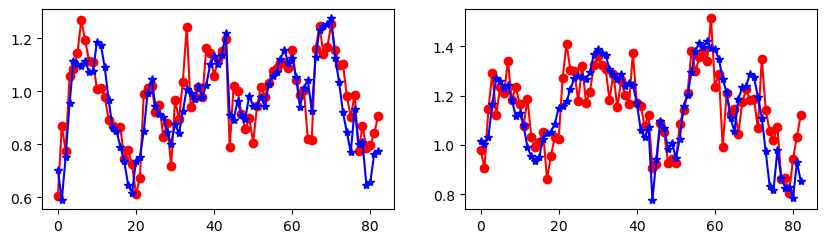

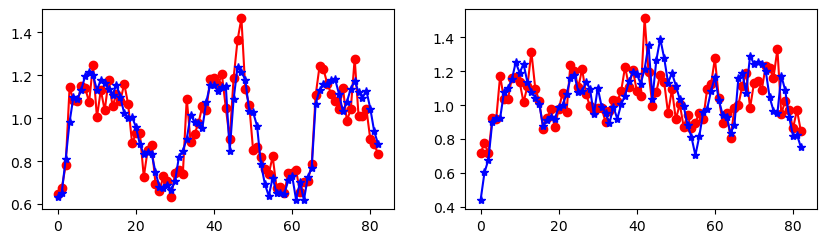

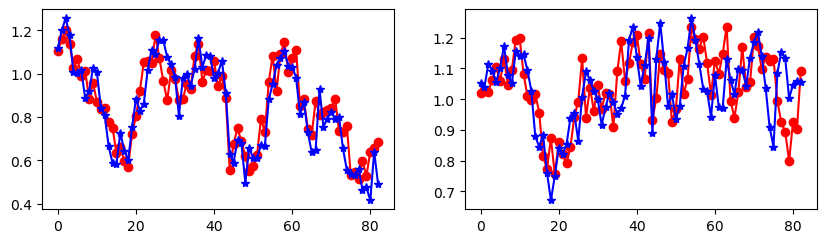

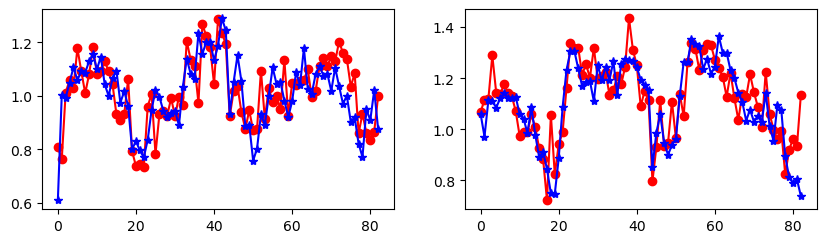

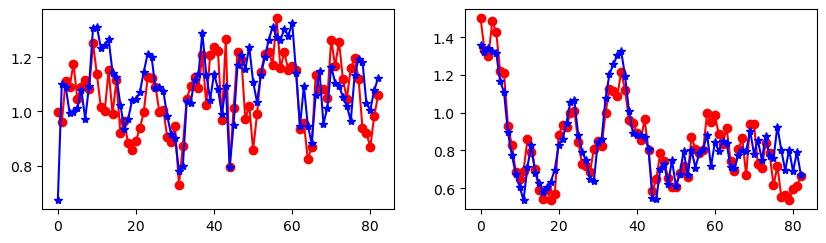

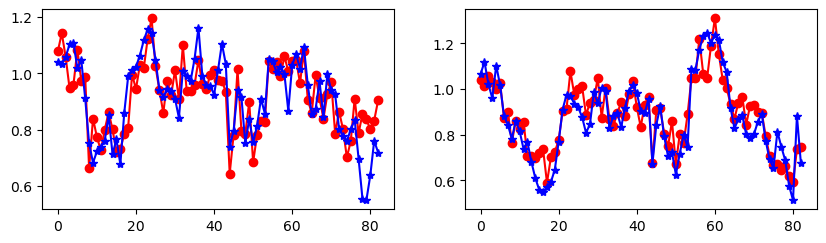

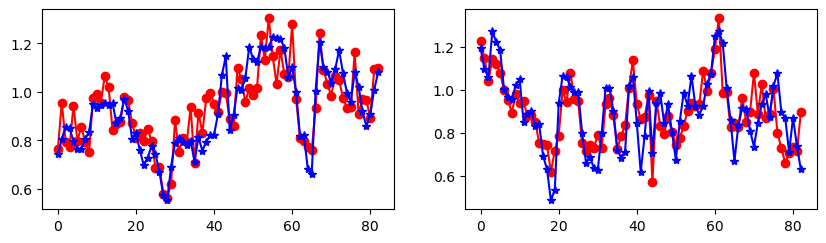

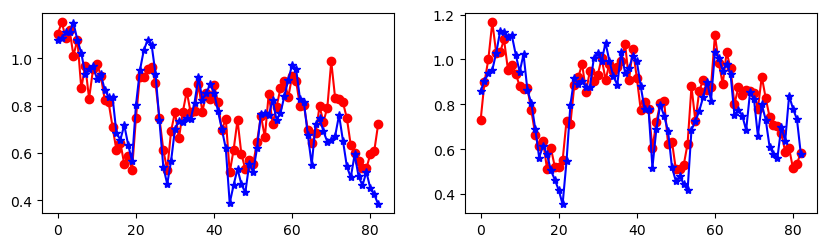

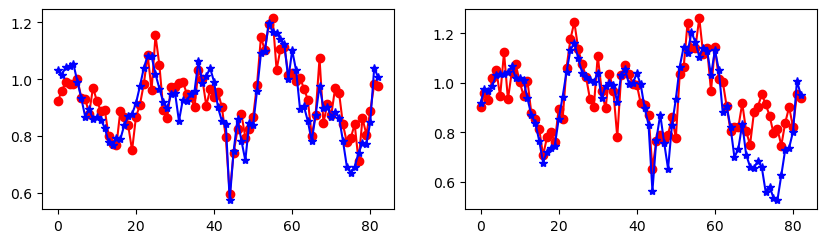

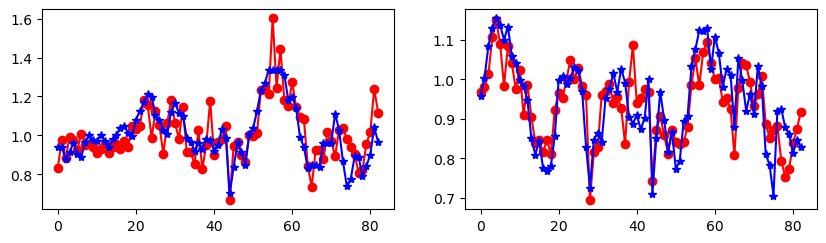

In [35]:
import matplotlib.pyplot as plt
#print(re_y_pre.T)
x= range(re_y_pre.shape[0])
for i in range(10):
    # 创建图形和子图
    fig, axs = plt.subplots(1, 2, figsize=(10, 2.6))  # 1行2列的子图布局

    axs[0].plot(x, re_y_pre[:,2*i],marker='o', linestyle='-', color='r')  # 使用红色线和圆形标记点
    axs[0].plot(x, re_y_real[:,2*i],marker='*', linestyle='-', color='b')  # 使用红色线和圆形标记点
    
    axs[1].plot(x, re_y_pre[:,2*i+1],marker='o', linestyle='-', color='r')  # 使用红色线和圆形标记点
    axs[1].plot(x, re_y_real[:,2*i+1],marker='*', linestyle='-', color='b')  # 使用红色线和圆形标记点
    
    #plt.plot(x, x_train[:,1,-1,1234].cpu().detach().numpy(),marker='o', linestyle='-', color='y')  # 使用红色线和圆形标记点
    plt.show()